In [1]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator
from qvarnet.models.mlp import MLP
from qvarnet.samplersv2 import MetropolisHastingsSampler


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.linalg import vector_norm

LOGGER_COUNT = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

# Test

$$\Psi = N\phi$$

where $\int \Psi^2=1$, and $\phi$ is our ansatz. Then:

$$1 = N^2\int \phi^2$$

so 

$$N = \frac{1}{\sqrt{\int\phi^2}}$$

And:

$$\Psi = \frac{\phi}{\sqrt{\int\phi^2}}$$

Integral of |psi|^2: 2.1969642639160156
Using model: MockModel()
acceptance rate: 0.6619678521478521


(-3.0, 3.0)

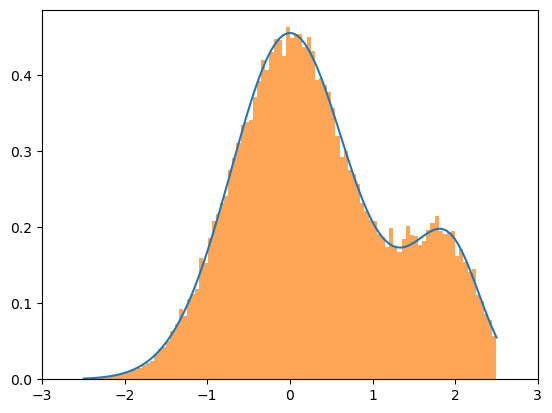

In [3]:
class MockModel(nn.Module):
    def __init__(self, model="gaussian"):
        super(MockModel, self).__init__()
        # UNIFORM?
        self.model = model
    
    def forward(self, x):
        # A mock wavefunction that is a simple Gaussian

        if self.model == "gaussian":
            return torch.exp(-0.5 * x**2)
        elif self.model == "double_gaussian":
            return torch.exp(-0.5 * x**2) + 0.5 * torch.exp(-2 * (x - 2)**2)
        elif self.model == "uniform":
            return torch.ones_like(x)
        elif self.model == "exp":
            return torch.exp(-torch.abs(x))
        else:
            raise ValueError(f"Unknown model type: {self.model}")
    
model = MockModel(model =  "double_gaussian")  # Change to "gaussian", "double_gaussian", or "uniform" 
model.to(device)
    
# plt.plot(x.cpu().numpy(), model(x).cpu().detach().numpy()**2, label='Mock Wavefunction')

sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=50000,
    step_size=1,
    burn_in=1000,
    is_wf=True,
    PBC=5
)
sampler.to(device)

x0 = torch.tensor([0.0], device=device)

sampled_x = sampler(x0, method="parallel", n_walkers=50000)

x = torch.linspace(torch.min(sampled_x), torch.max(sampled_x), 100).view(-1, 1).to(device)
psi = model(x)

integral_psi_squared = torch.trapz(psi**2, x, dim=0)
print(f"Integral of |psi|^2: {integral_psi_squared.item()}")
psi = psi / torch.sqrt(integral_psi_squared)  # Normalize the wavefunction

def norm(x):
    return torch.sqrt(torch.mean(1)) ## TODO: Look into how to compute the normalization!!

# norm_0 = norm(psi)
# psi = psi / norm_0  # Normalize the wavefunction

# norm2 = norm(psi)

# print(f"Norm of the wavefunction after sampling: {norm2.item()}")

print(f"Using model: {model}")
print(f"acceptance rate: {sampler.get_acceptance_rate()}")

# Plot the wavefunction
plt.plot(x.cpu().numpy(), psi.cpu().detach().numpy()**2, label='Wavefunction')
plt.hist(sampled_x.cpu().numpy(), bins=100, density=True, alpha=0.7, label='Sampled');
plt.xlim(-3,3)
# print(psi.cpu().detach().numpy())

# Computation

Negative energies arose from the fact that the sampling was to narrow centered in the middle. 

- Local energy computes okay
- Look into sampling process: PBC implemented, walkers now are initialized uniformly inside the box


In [25]:
import logging
import time
from tqdm import tqdm
os.makedirs("logs", exist_ok=True)

# Generate timestamped log filename
timestamp = time.strftime('%Y-%m-%d_%H-%M-%S')
log_filename = f"logs/{LOGGER_COUNT}_qvarnet_{timestamp}.log"
LOGGER_COUNT += 1
# Create logger
logger = logging.getLogger(f"qvarnet.{timestamp}")
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevents double logging if root logger has handlers

# Create file handler (no StreamHandler)
file_handler = logging.FileHandler(log_filename, mode='w')
file_handler.setLevel(logging.INFO)

# Set formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add handler to logger
logger.addHandler(file_handler)

#----------------------- DEFINE PARAMETERS -----------------------
EPOCHS             = 1000
N_SAMPLES          = 6_000
L_BOX              = 20.0
STEP_SIZE          = 0.25
BURN_IN            = 100
CALLBACK_PATIENCE  = 250
CALLBACK_MIN_DELTA = 1e-5
LEARNING_RATE      = 0.01
MLP_LAYER_DIMS     = [1, 4, 1]
DEBUG              = False

wf_history = []
samples_history = []

#----------------------- DEFINE MODEL TOPOLOGY -----------------------
model = MLP(layer_dims=MLP_LAYER_DIMS)
model.to(device)

# init weights
for layer in model.children():
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='tanh')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

if DEBUG:
    print("Model parameters after initialization:")
    for name, param in model.named_parameters():
        print(f"Parameter {name} initialized with shape {param.shape}, device {param.device} and values {param.data.cpu().numpy() if param is not None else None}")

#------------------------ DEFINE HAMILTONIAN -----------------------
hamiltonian = HarmonicOscillator(model=model)
hamiltonian.to(device)

#------------------------ DEFINE SAMPLER -----------------------
sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=N_SAMPLES,
    step_size=STEP_SIZE,
    burn_in=BURN_IN,
    is_wf=True,
    PBC=L_BOX,
)
sampler.to(device)

callback = EarlyStoppingCallback(patience=CALLBACK_PATIENCE, min_delta=CALLBACK_MIN_DELTA)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in tqdm(range(EPOCHS)):
    optimizer.zero_grad()
    # Run sampler
    sampler.model = model
    # x0 = torch.randn(1, device=device)
    x0 = torch.tensor([0.0], device=device)  # Initial point for the sampler
    samples = sampler(x0, method="parallel", n_walkers=(N_SAMPLES//2000))
    samples.requires_grad = True
    
    # Compute the mean and std of the local energy
    hamiltonian.model = model
    local_energy = hamiltonian(samples)
    for i in range(len(local_energy)):
        if torch.isnan(local_energy[i]) or torch.isinf(local_energy[i]):
            print(f"Invalid local energy at index {i}: {local_energy[i]}")

    loss = local_energy.mean()
    if DEBUG:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
    energy = copy.deepcopy(loss.item())
    energy_std = local_energy.std().item() 

    callback(epoch, energy, model)
    if callback.stop_training:
        print("Early stopping triggered.")
        break
    
    wf_history.append(model.state_dict())
    samples_history.append(samples)

    if DEBUG:
        print("AFTER LOCAL ENERGY")
        for name, param in model.named_parameters():
            if param is not None:
                print(f"Parameter {name} has shape {param.shape}, device {param.device}, and values {param.data.cpu().numpy() if param is not None else None}")
    
    # Compute gradients
    loss.squeeze().backward()
    if DEBUG:
        print("------------------AFTER BACKWARD:------------------")
        for name, param in model.named_parameters():
            if param is not None:
                print(f"Parameter {name} has shape {param.shape}, device {param.device}, and values {param.data.cpu().numpy() if param is not None else None}")
                print(f"Parameter {name} grad has shape {param.grad.shape}, device {param.grad.device}, and values {param.grad.data.cpu().numpy() if param.grad is not None else None}")
    # Update model parameters
    optimizer.step()
    
    if DEBUG:
        print("------------------AFTER STEP:------------------")
        for name, param in model.named_parameters():
            if param is not None:
                print(f"Parameter {name} after update has shape {param.shape}, device {param.device}, and values {param.data.cpu().numpy() if param is not None else None}")
    
    # LOGGING -----------------------------------------------------------------
    logger.info(f"Epoch {epoch}, Energy: {energy:.4f} ± {energy_std:.4f}, Loss: {loss.item():.4f}")
    logger.info(f"Acceptance Rate: {sampler.get_acceptance_rate():.4f}")
    logger.info(f"Current Model Parameters:")
    for name, param in model.named_parameters():
        logger.info(f"  {name}: {param.data.cpu().numpy() if param is not None else None}")
        logger.info(f"  {name} grad: {param.grad.data.cpu().numpy() if param.grad is not None else None}")
    logger.info("-" * 50)
    # -------------------------------------------------------------------------
    
    sampler.reset_statistics()

print("Ended training.")

if DEBUG:
    print("-"*50)
    for name, param in model.named_parameters():
        if param is not None:
            print(f"Parameter {name} after update has shape {param.shape}, device {param.device}, and values {param.data.cpu().numpy() if param is not None else None}")

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 270/1000 [05:51<15:50,  1.30s/it]

Stopping training after 271 epochs due to no improvement in energy.
Early stopping triggered.
Ended training.


In [5]:
for name, params in model.named_parameters():
    if params is not None:
        print(f"Parameter {name} has shape {params.shape}, device {params.device}, and values {params.data.cpu().numpy() if params is not None else None}")

Parameter model.0.weight has shape torch.Size([2, 1]), device cuda:0, and values [[0.8301439 ]
 [0.20715797]]
Parameter model.0.bias has shape torch.Size([2]), device cuda:0, and values [ 0.3365348  -0.36611345]
Parameter model.2.weight has shape torch.Size([1, 2]), device cuda:0, and values [[-0.4599839  0.5611635]]
Parameter model.2.bias has shape torch.Size([1]), device cuda:0, and values [-0.6696431]


In [6]:
import re
import ast
from collections import OrderedDict
from glob import glob

filename = glob("logs/*.log")[-1] if glob("logs/*.log") else None
print(f"Log files found: {glob('logs/*.log')}")
print(f"Using log file: {filename}")

def parse_tensor_string(array_str):
    # Insert commas between numbers (handle scientific notation too)
    array_str = re.sub(r'(?<=\d)\s+(?=[\d-])', ', ', array_str.strip())
    array_str = re.sub(r'(?<!\d)(nan|NaN)', 'None', array_str)
    # count for spaces between ][ to be ],[
    array_str = re.sub(r'\]\s*\[', '], [', array_str)
    try:
        print(f"Parsing tensor string: {array_str}")
        return torch.tensor(ast.literal_eval(array_str), dtype=torch.float32)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing tensor string: {array_str}")
        print(f"Exception: {e}")
        return torch.tensor([], dtype=torch.float32)

def reconstruct_from_log(log_filename, model, epoch=0):
    
    param_dict = {}
    param_line_re = re.compile(r"model\.(\d+)\.(weight|bias): (.+)")
    grad_line_re = re.compile(r"model\.(\d+)\.(weight|bias) grad: (.+)")
    reading = False
    print(epoch)
    with open(log_filename, "r") as f:
        for line in f:
            if f"Epoch {epoch}" in line:
                reading = True
            if reading:
                if "------------------------" in line:
                    break
            # check that the array does not go over multiple lines
                if line.count('[') != line.count(']'):
                    # if the brackets are not balanced, keep reading until they are
                    while True:
                        next_line = next(f)
                        line += next_line
                        if line.count('[') == line.count(']'):
                            # erase \n 
                            line = line.replace('\n', ' ')
                            break
                param_match = param_line_re.search(line)
                if param_match:
                    # Extract the layer index, parameter type, and array string
                    print(f"Found parameter match: {line.strip()}")
                    print(f"Line: {line.strip()}")
                    print("-" * 50)
                    layer_idx, param_type, array_str = param_match.groups()
                    print(f"Layer index: {layer_idx}, Parameter type: {param_type}, Array string: {array_str}")
                    array = parse_tensor_string(array_str)
                    key = f"model.{layer_idx}.{param_type}"
                    param_dict[key] = array
    print(f"Parameters found in log file: {list(param_dict.keys())}")
    state_dict = OrderedDict()
    for name, param in model.named_parameters():
        print(f"Processing parameter: {name}")
        if name in param_dict:
            state_dict[name] = param_dict[name]
        else:
            print(f"Warning: Parameter {name} not found in log file. Initializing with zeros.")
            state_dict[name] = torch.zeros_like(param.data)
    
    # Reshape the state_dict to match the model's parameters
    for name, param in state_dict.items():
        for name_model, param_model in model.named_parameters():
            if name == name_model:
                if param.dim() != param_model.dim():
                    print(f"Warning: Parameter {name} has shape {param.shape}, expected {param_model.shape}. Reshaping.")
                    state_dict[name] = param.view(param_model.shape)
                break
    
    model.load_state_dict(state_dict)
    model.to(device)
    return state_dict


model_new = MLP(layer_dims=MLP_LAYER_DIMS)
# Reconstruct the model state from the log file
reconstructed_model_state = reconstruct_from_log(filename, model_new, epoch=0)
print("Reconstructed model state:")
for name, param in reconstructed_model_state.items():
    print(f"{name}: {param.shape} - {param.cpu().numpy()}")

Log files found: ['logs/0_qvarnet_2025-06-20_11-59-28.log', 'logs/0_qvarnet_2025-06-20_13-11-41.log', 'logs/0_qvarnet_2025-06-20_13-11-21.log', 'logs/0_qvarnet_2025-06-20_11-39-44.log']
Using log file: logs/0_qvarnet_2025-06-20_11-39-44.log
0
Found parameter match: 2025-06-20 11:39:47,755 - INFO -   model.0.weight: [[-0.37883687]  [ 0.37357795]]
Line: 2025-06-20 11:39:47,755 - INFO -   model.0.weight: [[-0.37883687]  [ 0.37357795]]
--------------------------------------------------
Layer index: 0, Parameter type: weight, Array string: [[-0.37883687]  [ 0.37357795]] 
Parsing tensor string: [[-0.37883687], [ 0.37357795]]
Found parameter match: 2025-06-20 11:39:47,755 - INFO -   model.0.bias: [0.34267712 0.7997833 ]
Line: 2025-06-20 11:39:47,755 - INFO -   model.0.bias: [0.34267712 0.7997833 ]
--------------------------------------------------
Layer index: 0, Parameter type: bias, Array string: [0.34267712 0.7997833 ]
Parsing tensor string: [0.34267712, 0.7997833 ]
Found parameter match: 

Reconstructed model energy: 10.42667007446289
current model energy: 10.43570327758789
Parameter model.0.weight after reconstruction: [-0.37883687  0.37357795]
Parameter model.0.bias after reconstruction: [0.34267712 0.7997833 ]
Parameter model.2.weight after reconstruction: [-0.21726327 -0.35473514]
Parameter model.2.bias after reconstruction: [-0.21344249]


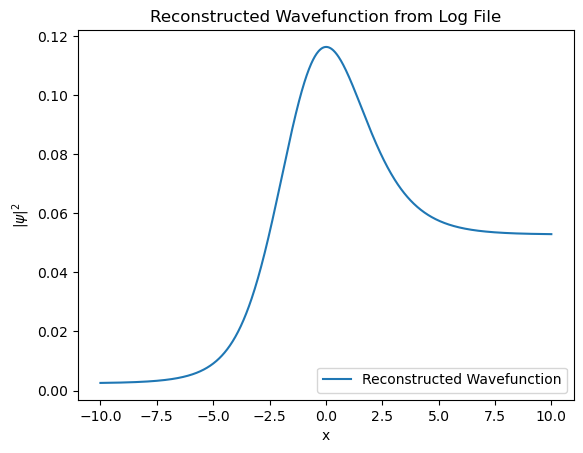

In [7]:
x_plotting = torch.linspace(-L_BOX/2, L_BOX/2, 1000).view(-1, 1).to(device)
x_plotting.requires_grad = True  # Ensure x_plotting is differentiable
psi_plotting = model_new(x_plotting)

def compute_energy(model, x):
    hamiltonian = HarmonicOscillator(model=model)
    hamiltonian.to(device)
    local_energy = hamiltonian(x)
    return local_energy.mean().item()

print(f"Reconstructed model energy: {compute_energy(model_new, samples_history[0])}")
print(f"current model energy: {compute_energy(model, samples_history[0])}")

for name, param in model_new.named_parameters():
    print(f"Parameter {name} after reconstruction: {param.data.cpu().numpy().flatten()}")
psi_plotting = psi_plotting / torch.sqrt(torch.trapz(psi_plotting**2, x_plotting, dim=0))  # Normalize the wavefunction
plt.plot(x_plotting.detach().cpu().numpy(), psi_plotting.cpu().detach().numpy()**2, label='Reconstructed Wavefunction')
plt.title("Reconstructed Wavefunction from Log File")
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.legend()
plt.show()

number of samples: 5000


(-10.0, 10.0)

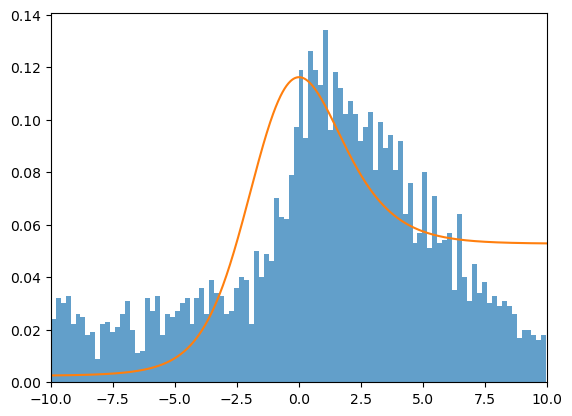

In [8]:
plt.hist(samples_history[0].detach().cpu().numpy(), bins=100, density=True, alpha=0.7, label='Sampled')
print(f"number of samples: {len(samples_history[0])}")
plt.plot(x_plotting.detach().cpu().numpy(), psi_plotting.cpu().detach().numpy()**2, label='Reconstructed Wavefunction')
plt.xlim(-L_BOX/2, L_BOX/2)

# Just sampling test

Execute this cell

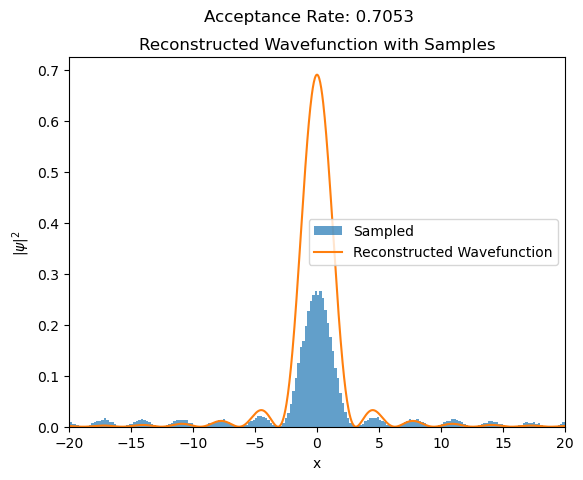

In [23]:
# PARAMETERS
N_SAMPLES = 100_000
L_BOX = 40.0
N_WALKERS = 200
STEP_SIZE = 0.1
LAYERS = [1, 60, 1]

# --------------------------- CODE ----------------------------
model = MLP(layer_dims=LAYERS)
model.to(device)

class FerranWeirdModel(nn.Module):
    def __init__(self, model="gaussian"):
        super(FerranWeirdModel, self).__init__()
        self.model = model

    def _sinc(self, x):
        # Sinc function: sin(x)/x, with a limit at x=0
        return torch.where(x != 0, torch.sin(x) / x, torch.ones_like(x))
    
    def forward(self, x):
        # return (torch.cos(2*x)-1)/x**2
        return self._sinc(x)**2
    
model = FerranWeirdModel()
model.to(device)

sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=N_SAMPLES,
    step_size=STEP_SIZE,
    burn_in=100,
    is_wf=False, # Ferran model is not wf
    assume_boltzmann=False,  # Ferran model is not Boltzmann
    PBC=L_BOX,
)
sampler.to(device)
x0 = torch.tensor([0.0], device=device)
# Run sampler
sampled_x = sampler(x0, method="parallel", n_walkers=N_WALKERS)
# Plot the wavefunction
x_plotting = torch.linspace(-L_BOX/2, L_BOX/2, 1000).view(-1, 1).to(device)
psi_plotting = model(x_plotting)
psi_plotting = psi_plotting / torch.sqrt(torch.trapz(psi_plotting**2, x_plotting, dim=0))  # Normalize the wavefunction

plt.hist(sampled_x.cpu().numpy(), bins=200, density=True, alpha=0.7, label='Sampled')
plt.plot(x_plotting.detach().cpu().numpy(), psi_plotting.cpu().detach().numpy(), label='Reconstructed Wavefunction')
plt.xlim(-L_BOX/2, L_BOX/2)
plt.title("Reconstructed Wavefunction with Samples")
plt.suptitle(f"Acceptance Rate: {sampler.get_acceptance_rate():.4f}")
plt.xlabel("x")
# plt.semilogy()
plt.ylabel(r"$|\psi|^2$")
plt.legend()
plt.show()

# Check norm is well computed

In [10]:
x = torch.tensor([1.,1.], device=device).view(1, -1)
norm = vector_norm(x)
print(f"Norm of x: {norm.item()}") # should be sqrt(2)
assert torch.isclose(norm, torch.sqrt(torch.tensor(2.0, device=device))), "norm computation error"
# Normalize the vector
x_normalized = x / norm
norm_x_normalized = vector_norm(x_normalized)
assert torch.isclose(norm_x_normalized, torch.tensor(1.0, device=device)), "normalized vector norm should be 1"
print(f"Norm of normalized x: {norm_x_normalized.item()}")

Norm of x: 1.4142135381698608
Norm of normalized x: 0.9999999403953552


# Analytic local energy for the QHO

$$\psi(x) = \frac{1}{\pi^{1/4}}\exp \bigg(-\frac{1}{2}x^2\bigg)$$

$$E_L(x) = \frac{H\psi}{\psi} = -\frac{1}{2\psi}\partial_{x}^2\psi + \frac{1}{2}x^2 = -\frac{1}{2\exp \bigg(-\frac{1}{2}x^2\bigg)}\exp \bigg(-\frac{1}{2}x^2\bigg)(x^2-1)+\frac{1}{2}x^2= -\frac{1}{2}(x^2-1)+\frac{1}{2}x^2 = \frac{1}{2}$$

(0.4, 0.6)

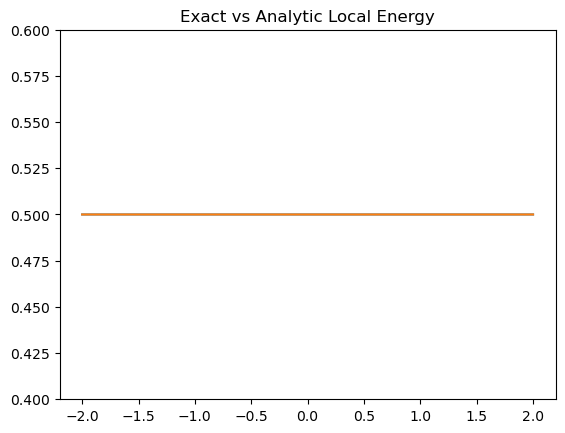

In [11]:
def analytic_EL(x):
    kinetic = -0.5*(x**2-1)
    potential = 0.5*x**2
    return kinetic + potential

class ExactQHO(nn.Module):
    def __init__(self):
        super(ExactQHO, self).__init__()

    def forward(self, x):
        return (1/torch.pi)**(1/4) * torch.exp(-0.5 * x**2)

exact_model = ExactQHO()
exact_model.to(device)
hamiltonian = HarmonicOscillator(model=exact_model)
hamiltonian.to(device)
x_test_EL = torch.linspace(-2, 2, 10000).view(-1, 1).to(device)
x_test_EL.requires_grad = True
exact_EL = hamiltonian(x_test_EL)
plt.plot(x_test_EL.cpu().detach().numpy(), exact_EL.cpu().detach().numpy(), label='Exact EL')
plt.plot(x_test_EL.cpu().detach().numpy(), analytic_EL(x_test_EL).cpu().detach().numpy(), label='Analytic EL')
plt.title("Exact vs Analytic Local Energy")
plt.ylim(0.4, 0.6)